IMPORT ALL THE REQUIRED LIBRARIES

In [1]:
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from scipy import linalg
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import HTML
import torchvision.utils as utils
from torch.utils.data import Subset
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.animation as animation
import torchvision.transforms as transforms

DEFINE THE PARAMETERS

In [2]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LEARNING_RATE = 5e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64 
FEATURES_GEN = 64 
beta = 0.5

In [3]:
import os
if not os.path.exists('Results'):
   os.makedirs('Results')
if not os.path.exists('Models'):
   os.makedirs('Models')

LOAD AND PREPROCESS THE CIFAR DATASET

In [4]:
dataset = datasets.CIFAR10(root="./CIFAR_dataset/CIFAR10data", download=False,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

BUILD A CNN-BASED DISCRIMINATOR FOR A GAN 

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self.Dnet(features_d, features_d * 2, 4, 2, 1),    
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1), 
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1), 
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

DEFINE A GENERATOR FOR THE MODEL

In [6]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self.Gnet(channels_noise, features_g * 16, 4, 1, 0),  
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),  
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1), 
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [7]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

INITIATE INSTANCES

In [8]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [9]:
optimGenerator = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(beta, 0.999))
optimDiscriminator = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(beta, 0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
step = 0

In [10]:
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [11]:
class InceptionV3(nn.Module):

    DEFAULT_BLOCK_INDEX = 3

    BLOCK_INDEX_BY_DIM = {
        64: 0,   
        192: 1, 
        768: 2, 
        2048: 3 
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

/home/mnarkhe/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mnarkhe/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [13]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [14]:
def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [15]:
GenLoss = []
DiscLoss = []
img_list = []
FID_list = []
iters = 0

print("========== Training Process Initiated ==========\n")
time_start = time.time()

for epoch in range(NUM_EPOCHS):
    epoch = epoch + 1
    print(f"Epoch {epoch}/{NUM_EPOCHS} in progress")
    
    for batch_idx, data in enumerate(dataloader, 0):

        real = data[0].to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        disc.zero_grad()
        loss_disc.backward()
        optimDiscriminator.step()

        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()

        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())
        
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader) - 1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
    fretchet_dist = calculate_fretchet(real, fake, model)
    FID_list.append(fretchet_dist)
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{NUM_EPOCHS} completed | Batch {batch_idx}/{len(dataloader)}")
        print(f"Discriminator Loss: {loss_disc:.4f} | Generator Loss: {loss_gen:.4f} | FID: {fretchet_dist:.4f}\n")
       
    images = gen(fixed_noise)
    os.makedirs('Results/DCGAN_FAKE', exist_ok=True)
    os.makedirs('Results/DCGAN_REAL', exist_ok=True)
    utils.save_image(images.detach(), f'Results/DCGAN_FAKE/DCGAN50_epoch_{epoch:03d}.png', normalize=True)
    utils.save_image(real.detach(), f'Results/DCGAN_REAL/DCGAN50_epoch_{epoch:03d}.png', normalize=True)

time_end = time.time()

elapsed_time = time_end - time_start
print("========== Training Completed ==========")
print(f"Total Training Time: {elapsed_time:.2f} seconds")


========== Training Process Initiated ==========

Epoch 1/40 in progress
Epoch 2/40 in progress
Epoch 3/40 in progress
Epoch 4/40 in progress
Epoch 5/40 in progress
Epoch 5/40 completed | Batch 781/782
Discriminator Loss: 0.4226 | Generator Loss: 1.9275 | FID: 280.2794

Epoch 6/40 in progress
Epoch 7/40 in progress
Epoch 8/40 in progress
Epoch 9/40 in progress
Epoch 10/40 in progress
Epoch 10/40 completed | Batch 781/782
Discriminator Loss: 0.2657 | Generator Loss: 2.6508 | FID: 281.7650

Epoch 11/40 in progress
Epoch 12/40 in progress
Epoch 13/40 in progress
Epoch 14/40 in progress
Epoch 15/40 in progress
Epoch 15/40 completed | Batch 781/782
Discriminator Loss: 0.2949 | Generator Loss: 2.3240 | FID: 281.0485

Epoch 16/40 in progress
Epoch 17/40 in progress
Epoch 18/40 in progress
Epoch 19/40 in progress
Epoch 20/40 in progress
Epoch 20/40 completed | Batch 781/782
Discriminator Loss: 0.1660 | Generator Loss: 4.6705 | FID: 284.6265

Epoch 21/40 in progress
Epoch 22/40 in progress
Epoc

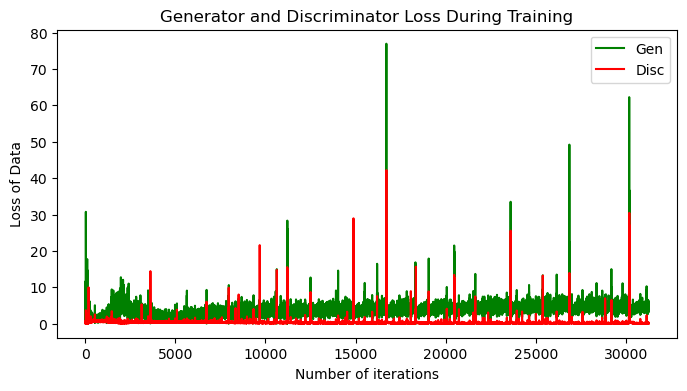

In [16]:
if not os.path.exists('Results/Loss_Data'):
       os.makedirs('Results/Loss_Data')
np.save('Results/Loss_Data/DCGAN_GLoss', GenLoss) 
np.save('Results/Loss_Data/DCGAN_DLoss', DiscLoss) 
GenLoss = np.load('Results/Loss_Data/DCGAN_GLoss.npy')
DiscLoss = np.load('Results/Loss_Data/DCGAN_DLoss.npy')
plt.figure(figsize=(8,4))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss, label="Gen", color="green")
plt.plot(DiscLoss, label="Disc", color="red")
plt.xlabel("Number of iterations")
plt.ylabel("Loss of Data")
plt.legend()
plt.savefig('Results/loss.pdf',
            format='pdf',
            bbox_inches='tight')
plt.show()

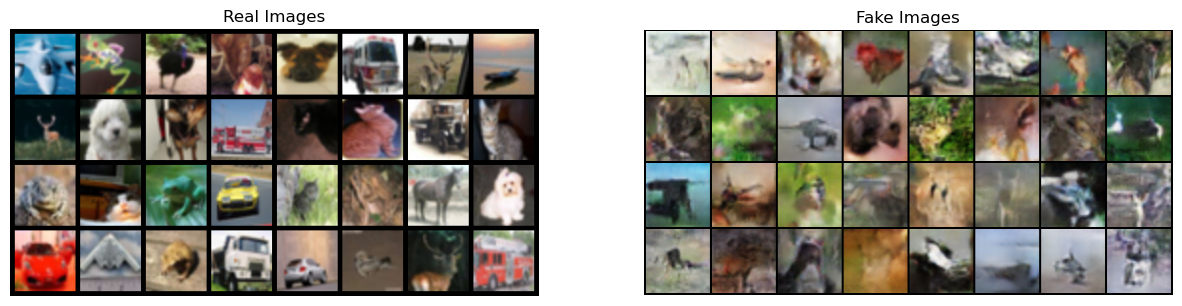

In [17]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('Results/DCGAN30_BEST_FAKE_32.pdf',
            format='pdf',
            bbox_inches='tight')
plt.show()

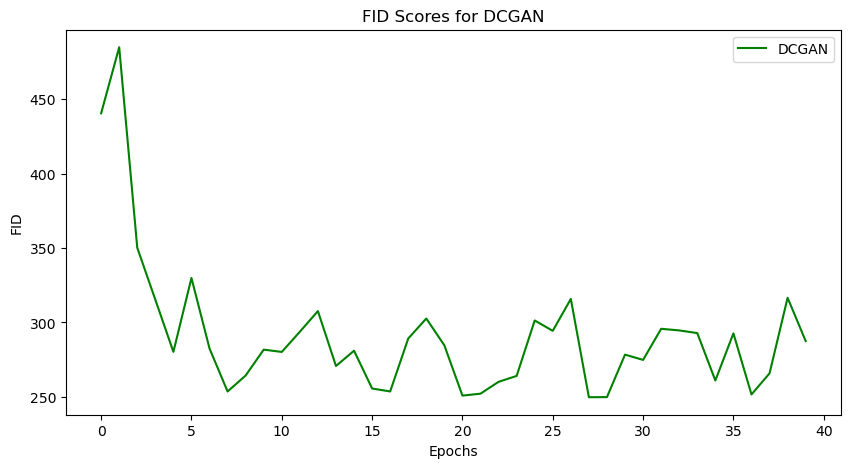

In [18]:
plt.figure(figsize=(10,5))
plt.title("FID Scores for DCGAN")
plt.plot(FID_list,label="DCGAN", color="green")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.show()

In [19]:
np.mean(GenLoss),np.mean(DiscLoss),np.min(GenLoss),np.min(DiscLoss),GenLoss[-1],DiscLoss[-1]

(3.5387073, 0.31481862, 0.00033623978, 0.0012270232, 5.3024783, 0.087610185)

In [20]:
np.min(FID_list), np.max(FID_list), np.mean(FID_list), FID_list[-1]

(249.81396920814365, 484.8019630375868, 291.3260138969855, 287.5192298678154)